Now to take the metric we made in eval_light and turn it into a full fledged metric that runs in MAF

In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import healpy as hp

import lsst.sims.maf.db as db
import lsst.sims.maf.metrics as metrics
import lsst.sims.maf.slicers as slicers
import lsst.sims.maf.metricBundles as metricBundles

In [2]:
# our simple light curve function from before
def simple_lc(mjd, mjd0, filtername):
    """
    Parameters
    ----------
    mjd : float array
        The MJDs to evaluate the LC at
    mjd0 : float
        The start time for the light curve
    filtername : str array
        The filter for each observation. Should be same length as mjd
    """
    duration = 10. # we'll say it's 10 days
    result = mjd * 0 + np.inf # mag is infinate everywhere by default
    #let's say this is a top-hat that only shows up in g and r
    g_on = np.where((mjd > mjd0) & (mjd < (mjd0+duration)) & (filtername=='g'))[0]
    result[g_on] = 22.
    r_on = np.where((mjd > mjd0) & (mjd < (mjd0+duration)) & (filtername=='r'))[0]
    result[r_on] = 23.8
    
    return result

In [3]:
# Connect to the database, set a directory to hold all the output
dbFile = 'baseline_v1.5_10yrs.db'
conn = db.OpsimDatabase(dbFile)
outDir='temp'
resultsDb = db.ResultsDb(outDir=outDir)

In [4]:
# now to define a new metric
class Lc_detected(metrics.BaseMetric):
    def __init__(self, m5Col='fiveSigmaDepth', filterCol='filter',
                 mjdCol='observationStartMJD', metricName='lc_detect',
                 **kwargs):
        self.m5Col = m5Col
        self.filterCol = filterCol
        self.mjdCol = mjdCol
        super().__init__(col=[m5Col, filterCol, mjdCol], metricName=metricName, **kwargs)
        
    def run(self, dataSlice, slicePoint=None):
        """ Return 1 if lightcurve is detected, 0 if not.
        """
        result = 0
        # Generate the light curve
        lc = simple_lc(dataSlice[self.mjdCol],
                       slicePoint['mjd0'], dataSlice[self.filterCol])
        # See if any of the points are brighter than the 
        # 5-sigma depth
        detected = np.where(lc < dataSlice[self.m5Col])[0]
        if np.size(detected) > 0:
            result = 1
        return result

In [5]:
bundleList = []
# We said this is only going to be in g and r. It'll work with sql='', but this should be faster
sql = 'filter="g" or filter="r"'
metric = Lc_detected()
slicer = slicers.HealpixSlicer(nside=32)
# We need to set the mjd0. Can set a single value, or an array
slicer.slicePoints['mjd0'] = 63506
summaryStats = [metrics.MeanMetric()]
plotDict = {}
bundleList.append(metricBundles.MetricBundle(metric,slicer,sql,
                                             plotDict=plotDict,
                                             summaryMetrics=summaryStats))

Healpix slicer using NSIDE=32, approximate resolution 109.935565 arcminutes


In [6]:
bg = metricBundles.MetricBundleGroup(bundleList, conn, outDir=outDir, resultsDb=resultsDb)
bg.runAll()

Querying database SummaryAllProps with constraint filter="g" or filter="r" for columns ['observationStartMJD', 'fiveSigmaDepth', 'fieldRA', 'filter', 'fieldDec']
Found 715547 visits
Running:  ['opsim_lc_detect_g_or_r_HEAL']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.


Plotting figures with "filter="g" or filter="r"" constraint now.


/Users/yoachim/git_repos/sims_maf/python/lsst/sims/maf/utils/mafUtils.py:56: RuntimeWarning: divide by zero encountered in double_scalars
  nbins = (binmax - binmin) / binwidth
/Users/yoachim/git_repos/sims_maf/python/lsst/sims/maf/utils/mafUtils.py:58: UserWarning: Optimal bin calculation tried to make inf bins, returning 200
  warnings.warn('Optimal bin calculation tried to make %.0f bins, returning %i'%(nbins, nbinMax))


monopole: 0.0525007  dipole: lon: -1.38361, lat: -11.4789, amp: 0.115643
Plotting complete.


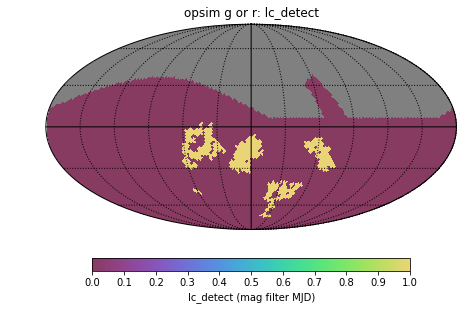

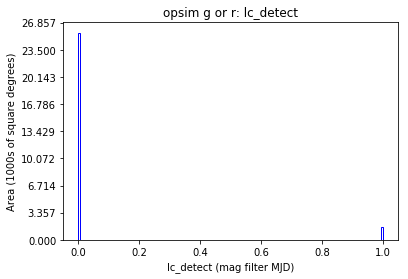

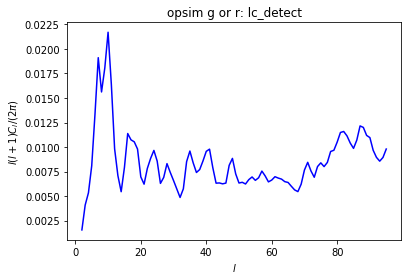

In [7]:
bg.plotAll(closefigs=False)

In [8]:
bundleList[0].summaryValues

{'Mean': 0.060490328939263274}

In [9]:
bundleList[0].metricValues

masked_array(data=[--, --, --, ..., 0.0, 0.0, 0.0],
             mask=[ True,  True,  True, ..., False, False, False],
       fill_value=-1.6375e+30)

In [ ]:
# Maybe point to some other handy metrics to look at. One that uses dust, one that uses stellar density
# One that does the Monte Carlo of a population